This notebook does the following process:

1. Fetch and parse current dublin bikes data
2. Check expected waiting times for empty stations based on historical data
3. Calculate walking distance to each existing bike station from current location
4. Combine walking distances and expected waiting times for all stations
5. Plot the route from current location to next available bike

In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import json
import requests

from PIL import Image
from io import BytesIO
from mpl_toolkits.basemap import Basemap
from pandas.io.json import json_normalize
from datetime import datetime, timedelta

In [212]:
# load preprocessed data from data_load_processing_viz.ipynb
full_data = pd.read_csv('full_data.csv', parse_dates=['DateTime'])
station_locations = pd.read_csv('station_locations.csv')

In [213]:
# get values from config file

with open('config.json') as config:
    config = json.load(config)

google_api_key = config['api_keys']['google_maps']
dublin_bikes_api_key = config['api_keys']['dublin_bikes']

bikes_base = config['hosts']['dublin_bikes']
dist_matrix_base = config['hosts']['google_distance_matrix']
directions_base = config['hosts']['google_directions']
staticmap_base = config['hosts']['google_static_map']

# parameters
# origins = '53.344389,-6.239678'  # bord gais energy theatre 
origins = '53.345761, -6.235113'  # my current location
num_time_intervals = 10  # how many 2 min intervals to consider in historical windows
n = 0  # returns the nth nearest bike station

In [214]:
# helper functions 

def get_lambda(data, start_timestamp, periods):
    """
    Given a date and a number of time periods to consider, calculate the historical estimate
    for rate parameter lambda (events/time) for the data
    """
    end_timestamp = start_timestamp + timedelta(minutes=2*periods)
    subset_day = data[data.index.dayofweek == start_timestamp.dayofweek]
    subset_time = subset_day.between_time(start_timestamp.time(), end_timestamp.time())
    lambda_vals = subset_time.mean(axis=0)
    return lambda_vals

def calculate_expected_waiting_time(lambda_vals, periods):
    """
    Convert lambda vector into vector of expected waiting times according to
    the exponential distribution
    """
    expected_vals = 1/lambda_vals
    expected_vals[expected_vals == np.inf] = periods  # heuristic
    expected_vals[expected_vals == 1] = 0  # heuristic
    return expected_vals

def parse_coords(coords):
    latitude = coords[0]
    longitude = coords[1]
    return '{},{}'.format(str(latitude), str(longitude))


def to_formatted_string(latlon_df):
    """Convert DataFrame of lat-lons to google api string format"""
    coords_series = latlon_df[['Latitude', 'Longitude']].apply(parse_coords, axis=1)
    formatted_string = coords_series.str.cat(sep='|')
    return formatted_string

def format_coords(data, max_locations=25):
    """
    Format DataFrame containing latitude and longitude values to send to googles
    distance matrix api and account for upper limit of coordinates per call.
    
    See: https://developers.google.com/maps/documentation/distance-matrix/intro
    """
    num_chunks = data.shape[0]//max_locations
    split_data = np.array_split(data, num_chunks)
    list_of_formatted_coords = [to_formatted_string(data) for data in split_data]
    return list_of_formatted_coords

def extract_durations(resp_json_payload):
    """Parse durations from google distance matrix output"""
    output_df = json_normalize(resp_json_payload['rows'][0]['elements'])
    durations = output_df['duration.value']
    return durations

def call_api(url):
    response = requests.get(url)
    resp_json_payload = response.json()
    return resp_json_payload

def make_url(base, **kwargs):
    """format URL for api calls"""
    args = ('&'.join(['%s=%s' % (key, value) for (key, value) in kwargs.items()]))
    return base + args

Get and format live Dublin bikes data using their API

In [215]:
# get live station info from dublin bikes

url = make_url(bikes_base, apiKey=dublin_bikes_api_key)
live_station_info = call_api(url)

In [216]:
live_info = json_normalize(live_station_info)

# subset based on the stations in our data (note: 4 stations from our historical data no longer exist)
live_info_reduced = live_info[live_info['name'].isin(list(station_locations['Name']))]
live_info_reduced = live_info_reduced[['name', 'available_bikes']]

# we will define any station with less than 2 bikes as empty
live_info_reduced['empty'] = live_info_reduced['available_bikes'] < 2
index = [station.replace(' ', '_') for station in live_info_reduced['name']]
live_info_reduced.index = index

Estimate station waiting time based on historical data. We will assume that time until station becomes non-empty is exponentially distributed:  $f(x; \lambda) = \lambda\mathrm{e}^{-\lambda x}$, and we will estimate parameter $\lambda$ based on our historical data for that given day and time window. Then the expected waiting time is simply $\frac{1}{\lambda}$.

In [218]:
# preprocess data
full_data.index = full_data['DateTime']
station_columns = [column_name for column_name in list(full_data.columns) if column_name.isupper()]
stations_df = full_data[station_columns]
stations_df_bool = stations_df.astype('bool') * 1

In [219]:
# calculate expected waiting times
timestamp = pd.Timestamp.now()  
lambda_vals = get_lambda(stations_df_bool, timestamp, num_time_intervals)
waiting_times = calculate_expected_waiting_time(lambda_vals, num_time_intervals)

In [220]:
# combine outputs to waiting times for empty stations
waiting_times.name = 'waiting_times'
stations_status = pd.concat([live_info_reduced, waiting_times/2], axis=1, sort=True)
stations_status['name'] = stations_status['name'].fillna(stations_status.index.to_series())
stations_status['empty'] = stations_status['empty'].fillna(True)  # assume missing stations are empty
stations_status['waiting_time_if_empty'] = stations_status['empty'] * stations_status['waiting_times']


Get walking duration from current location to all bike stations using googles distance matrix API

In [221]:
# getting durations to all stations using google distance matrix api main logic
station_locations.sort_values(by='Name', inplace=True)
destinations = format_coords(station_locations)
durations = []
for destinations_chunk in destinations:
    url = make_url(dist_matrix_base, mode='walking', origins=origins, destinations=destinations_chunk, key=google_api_key)
    response_json = call_api(url)
    durations_chunk = extract_durations(response_json)
    durations.extend(durations_chunk)


In [222]:
station_locations['duration'] = [duration/60 for duration in durations]
station_locations['Name'] = station_locations['Name'].str.replace(' ', '_')
station_locations['Name'] = station_locations['Name'].replace({'CHATHAM_STREET': 'CHATHAM_STREET/CLARENDON_ROW'})

In [223]:
# merge waiting times with travel times to obtain total time
merged_df = pd.merge(stations_status, station_locations, left_index=True, right_on='Name', how='inner')
merged_df['total_time'] = merged_df['waiting_time_if_empty'] + merged_df['duration']
summary_df = merged_df[['Name', 'Latitude', 'Longitude', 'duration', 'waiting_time_if_empty', 'total_time']].sort_values(by='total_time').reset_index(drop=True)


In [224]:
# ordered df of fastest locations to get a bike
summary_df.head()

,Name,Latitude,Longitude,duration,waiting_time_if_empty,total_time
0,HANOVER_QUAY,53.344115,-6.237153,3.733333,0.806452,4.539785
1,BENSON_STREET,53.344153,-6.233451,3.666667,0.961538,4.628205
2,LIME_STREET,53.346026,-6.243576,7.666667,0.000000,7.666667
3,GUILD_STREET,53.347932,-6.240928,7.666667,0.000000,7.666667
4,GRAND_CANAL_DOCK,53.342638,-6.238695,6.983333,0.694444,7.677778


Now lets explore two approaches for plotting the best route(s): firstly, using matplotlib/basemap and, secondly, using the google directions API

In [225]:
# get directions to a nth station 
latitude = summary_df.loc[n,'Latitude']
longitude = summary_df.loc[n,'Longitude']
destination = summary_df.loc[n, 'Name'].title().replace('_', ' ')
duration = np.round(summary_df.loc[n,'duration'], 2)
waiting_time_if_empty = np.round(summary_df.loc[n,'waiting_time_if_empty'], 2)
total_time = np.round(summary_df.loc[n,'total_time'], 2)

In [226]:
# call google directions api
url = make_url(directions_base, origin=origins, destination=parse_coords((latitude, longitude)), 
        mode='walking', key=google_api_key)
directions_json = call_api(url)


In [227]:
# parse output
directions_df = json_normalize(directions_json['routes'][0]['legs'][0]['steps'])
directions_df = directions_df[['start_location.lat', 'start_location.lng']].append(
    {'start_location.lat':latitude, 'start_location.lng':longitude}, ignore_index=True)
directions_df

,start_location.lat,start_location.lng
0,53.345762,-6.235113
1,53.345820,-6.235866
2,53.344123,-6.236219
3,53.344115,-6.237153


In [228]:
# plot with basemap/matplotlib
northeast_lat = directions_json['routes'][0]['bounds']['northeast']['lat'] + 0.001
northeast_lon = directions_json['routes'][0]['bounds']['northeast']['lng'] + 0.001
southwest_lat = directions_json['routes'][0]['bounds']['southwest']['lat'] - 0.001
southwest_lon = directions_json['routes'][0]['bounds']['southwest']['lng'] - 0.001

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=-694425.789060716,7046720.388020907,-693978.2513118797,7047409.67886056&bboxSR=3857&imageSR=3857&size=500,770&dpi=96&format=png32&transparent=true&f=image


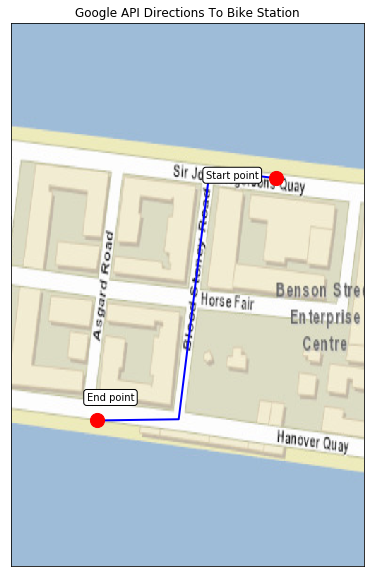

In [229]:
# rough plot of the route
fig, ax = plt.subplots(figsize=(20,10))
bmap = Basemap(epsg=3857, llcrnrlon=southwest_lon, llcrnrlat=southwest_lat,
          urcrnrlon=northeast_lon, urcrnrlat=northeast_lat, ax=ax, resolution='c') 
bmap.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 500, verbose= True)
lats, lons = bmap(list(directions_df['start_location.lng']), list(directions_df['start_location.lat']))

plt.plot(lats, lons, zorder=1, lw=2, c='b')
plt.scatter(lats[0], lons[0], marker='o', s=200, c='r', zorder=2)
plt.annotate(xy=(lats[0], lons[0]), textcoords='offset points', xytext=(-70,0), s='Start point', bbox=dict(boxstyle='round,pad=0.3', fc='white'))
plt.scatter(lats[-1], lons[-1], marker='o', s=200, c='r', zorder=3)
plt.annotate(xy=(lats[-1], lons[-1]), textcoords='offset points', xytext=(-10,20), s='End point', bbox=dict(boxstyle='round,pad=0.3', fc='white'))
plt.title('Google API Directions To Bike Station')
plt.show()


In [230]:
# plot using googles own static map api
path = to_formatted_string(directions_df.rename(columns={'start_location.lat':'Latitude', 'start_location.lng':'Longitude'}))
coords = '|'.join([origins, parse_coords((latitude, longitude))])
url = make_url(staticmap_base, markers=coords, size='640x640', scale='2', path=path, key=google_api_key)

In [231]:
respones_img = requests.get(url)   
im = Image.open(BytesIO(respones_img.content))

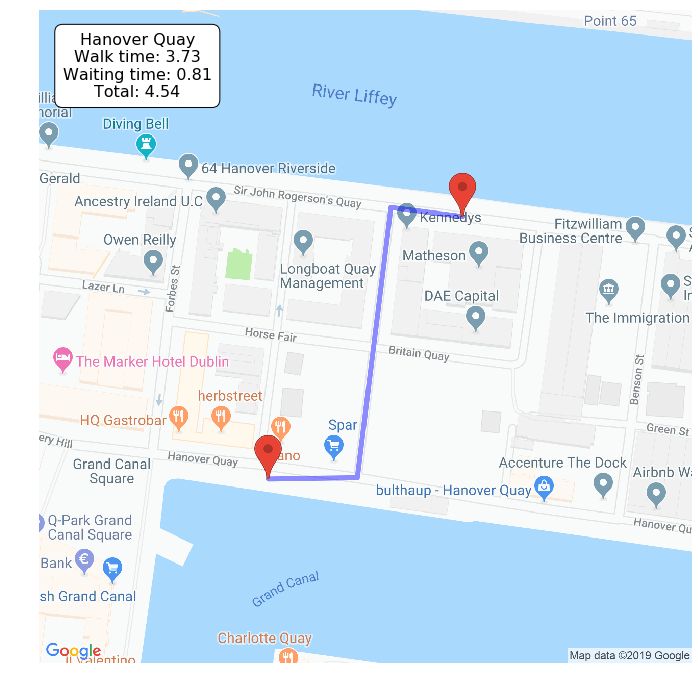

In [232]:
fig, ax = plt.subplots(figsize=(12, 12))

plt.imshow(im)
label = '{}\nWalk time: {}\nWaiting time: {}\nTotal: {}'.format(destination, duration, waiting_time_if_empty, total_time)
plt.text(0.15, 0.915, label,
     horizontalalignment='center',
     verticalalignment='center', fontsize=16,
     transform = ax.transAxes, bbox=dict(boxstyle='round,pad=0.5', fc='white'))
plt.axis('off')
plt.savefig('visualisations/directions.png', bbox_inches='tight')
plt.show()